# Import data

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import random

# Implement on a sample

In [2]:
def make_noisy(img, noise_factor=0.3):
    normalized_img = img.astype("float32")/255.0
    noisy_img = np.clip(normalized_img + np.random.normal(0, 1, img.shape) * noise_factor, 0, 1)
    gray_img = cv2.cvtColor((noisy_img*255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    output = gray_img
    return output

Text(0.5, 1.0, 'noisy')

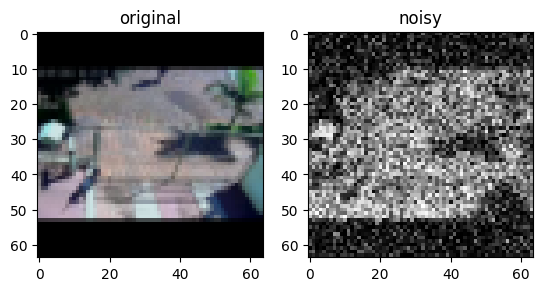

In [3]:
img = cv2.imread('./sample.png')
result = make_noisy(img, 0.3)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("original")
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title("noisy")

# Generate corrupted images

In [4]:
class CorruptingGenerator(Sequence):
    def __init__(self, img_paths, batch_size=16, noise= False, brightness= False, color= False, blur=False):
        self.paths= img_paths
        self.batch_size= batch_size
        self.noise= noise
        self.brightness = brightness
        self.color = color
        self.blur= blur
    
    # number of images in each batch computed
    def __len__(self):
        num = np.ceil(len(self.paths)/self.batch_size)
        return int(num)
    
    # current slice of images being processed
    def __getitem__(self,idx):
        batch_paths= self.paths[idx * self.batch_size:(idx+1) * self.batch_size]
        corrupted_batch=[]
        clean_batch=[]

        for path in batch_paths:
            img = cv2.imread(path)
            img = img.astype("float32") / 255.0
            corrupted= img.copy()


            if self.noise:
                noise = np.random.normal(0, 1, img.shape) * 0.3
                corrupted_img= np.clip(corrupted + noise, 0, 1)

            if self.brightness:
                factor = np.random.uniform(0.5,1.5)
                corrupted_img= np.clip(corrupted*factor , 0, 1)

            if self.color:
                channel_factors = np.random.uniform(0.8, 1.2, size=3)
                if np.random.rand() > 0.5:
                    channel_factors = 1/channel_factors
                corrupted = corrupted * channel_factors
                corrupted_img = np.clip(corrupted, 0, 1)

            if self.blur:
                corrupted_img = cv2.GaussianBlur(corrupted, (5, 5), sigmaX=1.0)



            corrupted_batch.append(corrupted_img)
            clean_batch.append(img)

        return np.array(corrupted_batch), np.array(clean_batch)

## Set up paths

In [5]:
folder = os.path.join("UCF-crime", "Train")
# target_classes = ["Abuse"]
img_paths_train = []

for video_name in os.listdir(folder):
    # if video_name not in target_classes:
    #     continue
    video_path= os.path.join(folder, video_name)

    if not os.path.isdir(video_path):
        continue

    for file_name in os.listdir(video_path):
        full_path= os.path.join(video_path, file_name)
        img_paths_train.append(full_path)

print(len(img_paths_train))

1266345


In [6]:
img_paths_train_slice= np.random.choice(img_paths_train, size=4500, replace=False)

In [7]:
folder = os.path.join("UCF-crime", "Test")
# target_classes = ["Abuse"]
img_paths_test = []

for video_name in os.listdir(folder):
    # if video_name not in target_classes:
    #     continue
    video_path= os.path.join(folder, video_name)

    if not os.path.isdir(video_path):
        continue

    for file_name in os.listdir(video_path):
        full_path= os.path.join(video_path, file_name)
        img_paths_test.append(full_path)

print(len(img_paths_test))

111308


In [8]:
img_paths_test_slice= np.random.choice(img_paths_test, size=500, replace=False)

# Generate corruption

In [9]:
gen_noise = CorruptingGenerator(
    img_paths= img_paths_train_slice,
    noise=True
)

# model.fit(gen_noise, epochs=5)


In [10]:
gen_brightness = CorruptingGenerator(
    img_paths= img_paths_train_slice,
    brightness=True
)

In [11]:
gen_color = CorruptingGenerator(
    img_paths= img_paths_train_slice,
    color=True
)

In [12]:
gen_blur = CorruptingGenerator(
    img_paths= img_paths_train_slice,
    blur=True
)

# Model

In [13]:
# train_gen = NoisyImageGenerator(
#     img_paths = img_paths_train_slice,
#     batch_size= 16,
#     noise_factor= 0.3
# )

In [14]:
height, width, channel = 64,64,3

In [15]:
# model
input_img = layers.Input(shape=(height,width,channel))

# Encoder
conv_1_1 = layers.Conv2D(32, kernel_size=(3,3), padding="same")(input_img)
conv_1_2 = layers.Conv2D(64, kernel_size=(3,3), activation="relu", padding="same")(conv_1_1)
pool_1 = layers.MaxPool2D(pool_size=(2,2))(conv_1_2)

conv_2 = layers.Conv2D(128,kernel_size=(3,3), activation="relu", padding="same")(pool_1)
pool_2 = layers.MaxPooling2D(pool_size=(2,2))(conv_2)

# Decoder
deconv_1= layers.Conv2DTranspose(128, kernel_size=(3,3), activation="relu", padding="same")(pool_2)
upsample_1= layers.UpSampling2D(size=(2,2))(deconv_1)

deconv_2_1= layers.Conv2DTranspose(64, kernel_size=(3,3), activation="relu", padding="same")(upsample_1)
deconv_2_2= layers.Conv2DTranspose(32, kernel_size=(3,3), activation="relu", padding="same")(deconv_2_1)
upsample_2= layers.UpSampling2D(size=(2,2))(deconv_2_2)

outputs = layers.Conv2D(channel, kernel_size=(3,3), activation="sigmoid", padding="same")(upsample_2)

auto_encoder_model = models.Model(
    input_img,
    outputs
)
auto_encoder_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
auto_encoder_model.compile(optimizer="adam", loss="mse", metrics=["mse"])

In [17]:
history = auto_encoder_model.fit(
    gen_noise,
    epochs = 5
)

c:\Users\sahar-rayane\AppData\Local\Programs\Python\Python313\my_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 241s 810ms/step - loss: 0.0156 - mse: 0.0156
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 109s 386ms/step - loss: 0.0084 - mse: 0.0084
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 109s 385ms/step - loss: 0.0075 - mse: 0.0075
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 106s 375ms/step - loss: 0.0071 - mse: 0.0071
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 105s 371ms/step - loss: 0.0067 - mse: 0.0067


In [18]:
history = auto_encoder_model.fit(
    gen_brightness,
    epochs = 5
)

Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 105s 365ms/step - loss: 0.0132 - mse: 0.0132
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 103s 367ms/step - loss: 0.0101 - mse: 0.0101
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 104s 367ms/step - loss: 0.0093 - mse: 0.0093
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 106s 375ms/step - loss: 0.0083 - mse: 0.0083
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 103s 366ms/step - loss: 0.0082 - mse: 0.0082


In [19]:
history = auto_encoder_model.fit(
    gen_color,
    epochs = 5
)

Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 106s 377ms/step - loss: 0.0053 - mse: 0.0053
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 104s 369ms/step - loss: 0.0045 - mse: 0.0045
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 104s 369ms/step - loss: 0.0045 - mse: 0.0045
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 113s 399ms/step - loss: 0.0042 - mse: 0.0042
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 114s 403ms/step - loss: 0.0041 - mse: 0.0041


In [20]:
history = auto_encoder_model.fit(
    gen_blur,
    epochs = 5
)

Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 116s 411ms/step - loss: 0.0032 - mse: 0.0032
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 116s 412ms/step - loss: 0.0027 - mse: 0.0027
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 116s 410ms/step - loss: 0.0026 - mse: 0.0026
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 117s 413ms/step - loss: 0.0024 - mse: 0.0024
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 111s 392ms/step - loss: 0.0024 - mse: 0.0024


# Model evaluation

In [21]:
test_gen =CorruptingGenerator(
    img_paths = img_paths_test_slice,
    batch_size= 16,
    noise= True,
    brightness= True,
    blur= True,
    color= True
)

In [22]:
y_pred = auto_encoder_model.predict(test_gen)
print(y_pred.shape)

32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 599ms/step
(500, 64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0850554692084056].


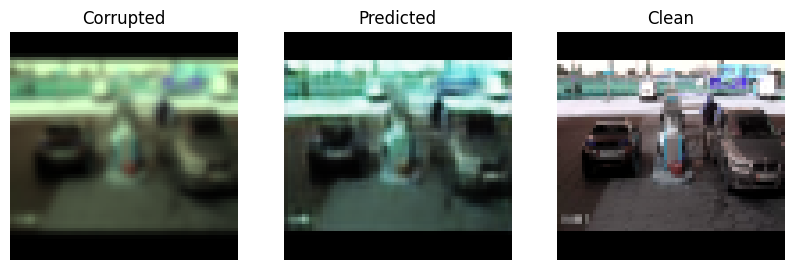

In [32]:
test_size = len(img_paths_test_slice)
batch_size= 16
batch_idx = random.randint(1, int(test_size/batch_size)-1)
img_idx = random.randint(1, batch_size-1)

corrupted_imgs, clean_imgs = test_gen[batch_idx]

plt.figure(figsize=(10,4))

# noisy
plt.subplot(1,3,1)
plt.title("Corrupted")
#cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(corrupted_imgs[img_idx], cmap="gray")
plt.axis("off")

# reconstructed
plt.subplot(1,3,2)
plt.title("Predicted")
plt.imshow(y_pred[batch_idx * batch_size + img_idx], cmap="gray")
plt.axis("off")

# clean
plt.subplot(1,3,3)
plt.title("Clean")
plt.imshow(clean_imgs[img_idx], cmap="gray")
plt.axis("off")

plt.show()
